In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PSO:

    def __init__(self, particles, velocities, fitness_function,
                 w=0.8, c_1=1, c_2=1, max_iter=100, auto_coef=True):
        self.particles = particles
        self.velocities = velocities
        self.fitness_function = fitness_function

        self.N = len(self.particles)
        self.w = w
        self.c_1 = c_1
        self.c_2 = c_2
        self.auto_coef = auto_coef
        self.max_iter = max_iter


        self.p_bests = self.particles
        self.p_bests_values = self.fitness_function(self.particles)
        self.g_best = self.p_bests[0]
        self.g_best_value = self.p_bests_values[0]
        self.update_bests()

        self.iter = 0
        self.is_running = True
        self.update_coef()

    def __str__(self):
        return f'[{self.iter}/{self.max_iter}] $w$:{self.w:.3f} - $c_1$:{self.c_1:.3f} - $c_2$:{self.c_2:.3f}'

    def next(self):
        if self.iter > 0:
            self.move_particles()
            self.update_bests()
            self.update_coef()

        self.iter += 1
        self.is_running = self.is_running and self.iter < self.max_iter
        return self.is_running

    def update_coef(self):
        if self.auto_coef:
            t = self.iter
            n = self.max_iter
            self.w = (0.4/n**2) * (t - n) ** 2 + 0.4
            self.c_1 = -3 * t / n + 3.5
            self.c_2 =  3 * t / n + 0.5

    def move_particles(self):

        # add inertia
        new_velocities = self.w * self.velocities
        # add cognitive component
        r_1 = np.random.random(self.N)
        r_1 = np.tile(r_1[:, None], (1, 2))
        new_velocities += self.c_1 * r_1 * (self.p_bests - self.particles)
        # add social component
        r_2 = np.random.random(self.N)
        r_2 = np.tile(r_2[:, None], (1, 2))
        g_best = np.tile(self.g_best[None], (self.N, 1))
        new_velocities += self.c_2 * r_2 * (g_best  - self.particles)

        self.is_running = np.sum(self.velocities - new_velocities) != 0

        # update positions and velocities
        self.velocities = new_velocities
        self.particles = self.particles + new_velocities


    def update_bests(self):
        fits = self.fitness_function(self.particles)

        for i in range(len(self.particles)):
            # update best personnal value (cognitive)
            if fits[i] < self.p_bests_values[i]:
                self.p_bests_values[i] = fits[i]
                self.p_bests[i] = self.particles[i]
                # update best global value (social)
                if fits[i] < self.g_best_value:
                    self.g_best_value = fits[i]
                    self.g_best = self.particles[i]

In [3]:
def obj(t, params):
    """Objective function to be minimized"""
    wder_min_w = (- x3dprime(np.array([0]), params) + x3d(np.array([0]), params)) * np.exp(-t)
    x1 = wder_min_w + x3dprime(t, params) - x3d(t, params)
    diff = np.abs(x1 - np.sin(t))
    error = 0
    for i in range(diff.shape[1] - 1):
        error += (diff[:,i+1] + diff[:,i]) * (t[i+1] - t[i]) / 2
    return error

In [4]:
def x3dprime(t, params):
    """First derivative of x3d"""
    N = params.shape[-1]
    trig_array = [0] * N
    for i in range(N):
        n = (i + 1) // 2
        if i == 0:
            trig_array[i] = np.zeros(len(t))
        elif i % 2 == 1:
            trig_array[i] = n * np.cos(n * t)
        else:   # i % 2 == 0
            trig_array[i] = n * -np.sin(n * t)
    return np.dot(params, trig_array)

In [5]:
def x3d(t, params):
    """Designed function for x3"""
    N = params.shape[-1]
    trig_array = [0] * N
    for i in range(N):
        n = (i + 1) // 2
        if i == 0:
            trig_array[i] = np.ones(len(t))
        elif i % 2 == 1:
            trig_array[i] = np.sin(n * t)
        else:   # i % 2 == 0
            trig_array[i] = np.cos(n * t)
    return np.dot(params, trig_array)

In [6]:
def PSO(obj, p_num, N, scale, w=1, r=0.99, c1=1, c2=1, eps=1e-5, 
        early_stopping=100, max_iter=1000, verbose=True, random_state=None):
    """Main algorithm"""
    
    # initialize
    np.random.seed(random_state)
    params_num = 2 * N + 1
    p = np.random.normal(scale=scale, size=(p_num, params_num))
    v = np.random.normal(scale=scale, size=(p_num, params_num))
    t = np.linspace(0, 4 * np.pi, 101)
    error = obj(t, p)
    pbest = p.copy()
    gbest = p[error.argmin()]
    best_params = [gbest]
    e = [error.min()]
    iter_num = 0
    count = 0
    if verbose == True:
        if len(gbest) <= 7:
            print(f'Initial condition:   params = {gbest}\n\t\t     error = {e[-1]:.4f}\n')
        else:
            print(f'Initial condition:\terror = {e[-1]:.4f}\n')
    
    # main algorithm
    while error.min() > eps and iter_num < max_iter and count < early_stopping:
        # create random numbers, used for updating particle position
        r1 = np.random.uniform(size=(params_num))
        r2 = np.random.uniform(size=(params_num))
        r1 = np.tile(r1, p_num).reshape(p_num, -1)
        r2 = np.tile(r2, p_num).reshape(p_num, -1)
        # update particle position
        v = w * v + c1 * r1 * (pbest - p) + c2 * r2 * (gbest - p)
        w = w * r
        p = p + v
        # calculate error
        error = obj(t, p)
        errorbest = obj(t, pbest)
        # update global best
        gbest = p[error.argmin()]
        # update personal best
        min_idx = np.array([error, errorbest]).argmin(axis=0)
        for i, idx in enumerate(min_idx):
            if idx == 0: pbest[i,:] = p[i,:].copy()
        # update tabulation
        iter_num += 1
        if error.min() >= e[-1]:
            count += 1
        else:
            count = 0
        e.append(error.min())
        best_params.append(gbest)
        # print result in terminal
        if verbose:
            if len(gbest) <= 7:
                print(f'Iteration: {iter_num}\tbest params = {gbest}\n\t\terror = {e[-1]:.4f}')
            else:
                print(f'Iteration: {iter_num}\terror = {e[-1]:.4f}')
    
    # in case max iteration reached
    if iter_num == max_iter:
        print(iter_num, 'maximum iterations reached!',
              'Try increasing max_iter or adjusting PSO parameters for better result.')
    
    # cut tabulation for early stopping
    if count == early_stopping:
        iter_num = iter_num - count
        best_params = best_params[:-early_stopping]
        e = e[:-early_stopping]
    
    # return the number of iterations needed, the best parameters, and error
    return iter_num, np.array(best_params), np.array(e)

Initial condition:   params = [ 0.09495541 -0.1484898  -0.25539211  0.09343199 -0.13668787 -0.02247654
 -0.1170113 ]
		     error = 5.1687

Iteration: 1	best params = [ 0.0927755  -0.21362726 -0.27093549  0.03259867 -0.07809236 -0.06604722
 -0.05491775]
		error = 4.0092
Iteration: 2	best params = [ 0.05924213 -0.60831061 -0.44058426  0.00973174 -0.1110429  -0.10339552
  0.00466473]
		error = 3.6121
Iteration: 3	best params = [ 0.03633298 -0.41886206 -0.51639705  0.01121816 -0.02136765  0.01099861
  0.02811054]
		error = 1.2643
Iteration: 4	best params = [ 0.02228551 -0.44441899 -0.56194997 -0.02799135 -0.00318641  0.04019016
 -0.01437692]
		error = 1.2772
Iteration: 5	best params = [-0.02058441 -0.48073809 -0.75248233 -0.05540162 -0.03671896  0.00695582
 -0.0454124 ]
		error = 2.7673
Iteration: 6	best params = [-0.01643002 -0.58378026 -0.62955889  0.01268006  0.02813037  0.02213365
 -0.02471005]
		error = 1.9027
Iteration: 7	best params = [-0.04396211 -0.49502018 -0.57084917 -0.0138530

Iteration: 60	best params = [ 1.11319419e-04 -5.00016700e-01 -5.00025310e-01  3.51352033e-05
  2.50011975e-05  5.64687705e-06  2.92507950e-05]
		error = 0.0014
Iteration: 61	best params = [-1.58118950e-05 -4.99951514e-01 -4.99981360e-01  2.80845551e-05
  2.23124204e-05  1.41216387e-05  2.03129437e-05]
		error = 0.0009
Iteration: 62	best params = [ 1.28268249e-05 -4.99999642e-01 -4.99955678e-01  1.64597319e-05
  9.46839152e-06  1.45803849e-06  8.06375241e-06]
		error = 0.0005
Iteration: 63	best params = [ 1.65822296e-05 -4.99995420e-01 -4.99942530e-01 -1.91140404e-06
  1.30188122e-05  1.77534488e-05  7.88818091e-06]
		error = 0.0007
Iteration: 64	best params = [ 1.50718489e-05 -4.99994131e-01 -4.99943628e-01 -1.11502524e-05
  1.15955089e-05  1.78824797e-05  7.80255779e-06]
		error = 0.0007
Iteration: 65	best params = [ 6.19535944e-06 -4.99978593e-01 -4.99997755e-01 -2.04128763e-05
  4.19868931e-06  9.27675414e-06  5.67779049e-06]
		error = 0.0005
Iteration: 66	best params = [ 2.82486456

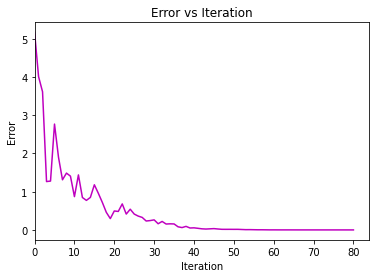

In [7]:
k, best_params, error = PSO(obj, p_num=800, N=3, scale=0.1, random_state=42)
plt.plot(error, c='m')
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.xlim(0)
plt.show()